In [1]:
# !pip install matplotlib
# !pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

In [143]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = False 

In [3]:
data_path = './input/data/train_dataset/train_data.csv'

In [4]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   
df = pd.read_csv(data_path, dtype=dtype, parse_dates=['Timestamp'])

# Data 확인

- level 추가 (assessmentItemID 활용)


In [111]:
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
df['level']=pd.Series([x[2] for x in df['assessmentItemID']])
df['level'] = df['level'].astype('int16')
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,level
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4


# Basic informations
- UserID : 문제를 푼 사람의 고유 ID
- assessmentItemID : 사용자가 푼 문제의 고유 값으로, 난이도와 문제번호
- testID : assessmentItemID의 상위 카테고리로, assessmentItemID의 시험지 ID
- KnowledgeTag : 같은 유형의 문제에 대한 TAG 값

In [30]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}명
assessmentItemID : {df.assessmentItemID.nunique()}개
testID           : {df.testId.nunique()}개
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}개
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698명
assessmentItemID : 9454개
testID           : 1537개
mean answer rate : 65.44%
KnowledgeTag     : 912개
--------------------------


## 사용자 별 Data

In [241]:
def percentile(s):
    return np.sum(s) / len(s)
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'testId':'nunique',
    'answerCode': percentile
})

In [242]:
stu_groupby_copy = stu_groupby.copy()
stu_groupby_copy['quiz/test_paper'] = stu_groupby_copy['assessmentItemID']/stu_groupby_copy['testId']
stu_groupby_copy.columns = ["총 푼 문제 수", "총 푼 문제지 수", "정답률",'평균적으로 푼 문제 수']
stu_groupby_copy

,총 푼 문제 수,총 푼 문제지 수,정답률,평균적으로 푼 문제 수
userID,,,,
0,745,104,0.630872,7.163462
1,933,153,0.853162,6.098039
2,276,48,0.612319,5.750000
5,833,119,0.795918,7.000000
6,921,169,0.442997,5.449704
...,...,...,...,...
7436,15,3,0.466667,5.000000
7437,16,3,0.375000,5.333333
7438,16,3,0.750000,5.333333


In [185]:
stu_groupby['quiz_test_paper'] = stu_groupby['assessmentItemID']/stu_groupby['testId']

In [197]:
print(f"""{'-'*35}
평균 푼 문  제 수    : {stu_groupby.assessmentItemID.mean().round(3)} 개
평균 푼 문제지 수    : {stu_groupby.testId.mean().round(3)} 개
평균 정답률          : {stu_groupby.answerCode.mean().round(3)*100}%
1 문제지당 푼 문제 수: {stu_groupby.quiz_test_paper.mean().round(3)}개
{'-'*35}""")

# stu_groupby[['assessmentItemID','testId']].mean()

-----------------------------------
평균 푼 문  제 수    : 338.397 개
평균 푼 문제지 수    : 54.518 개
평균 정답률          : 62.9%
1 문제지당 푼 문제 수: 6.139개
-----------------------------------


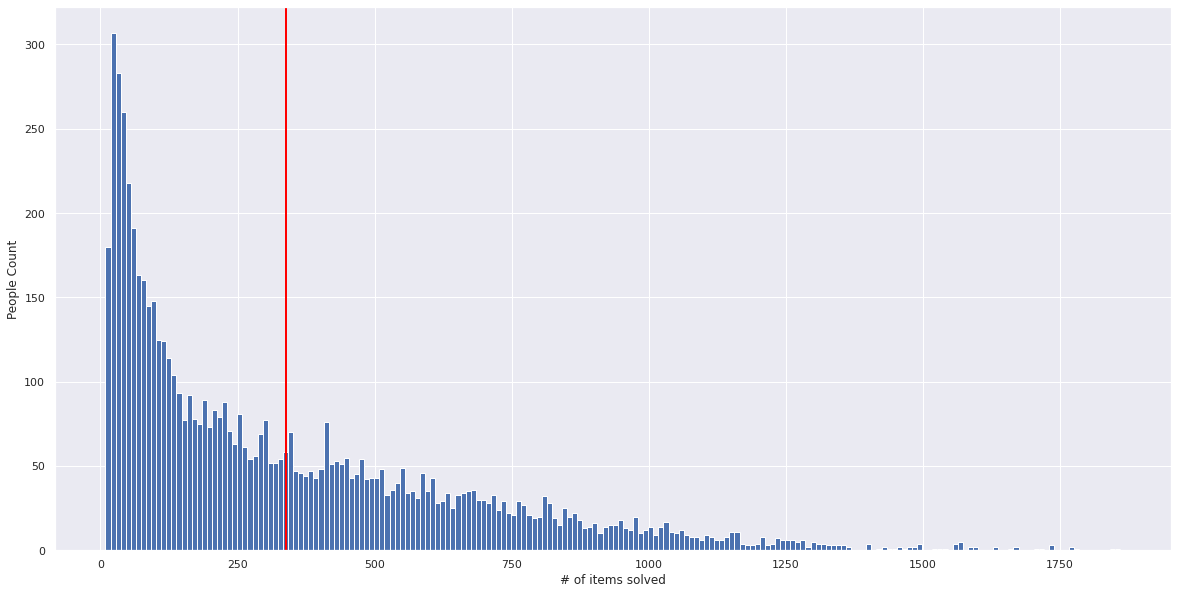

In [198]:
fig, ax = plt.subplots(figsize=(20,10))
stu_groupby['assessmentItemID'].hist(bins=200, ax=ax)
# ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('People Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

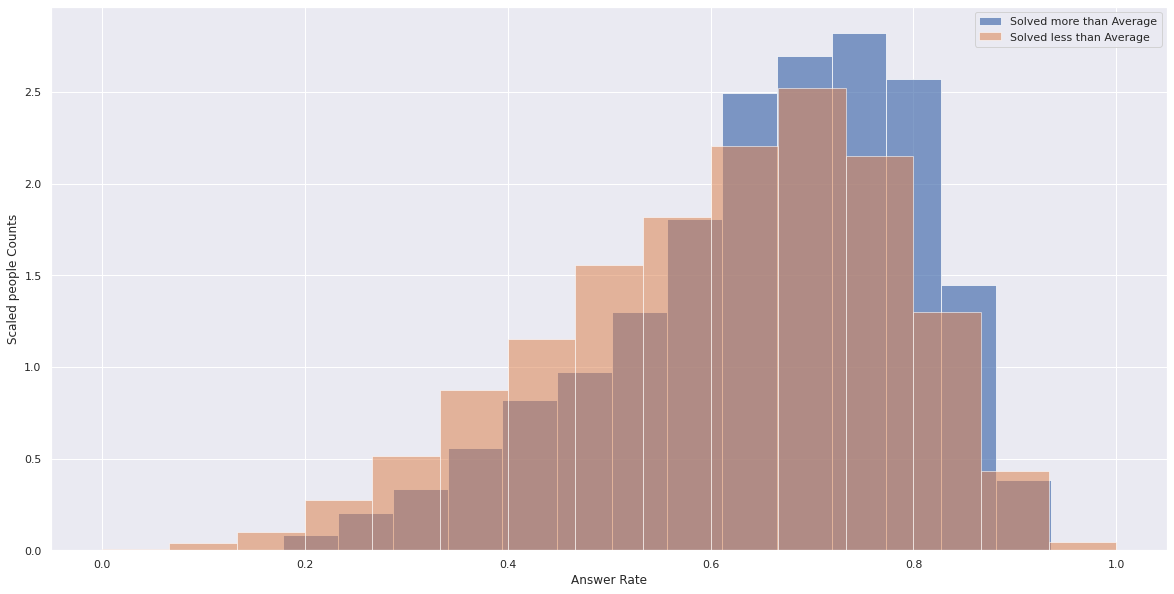

In [221]:
fig, ax = plt.subplots()
ans_mean = stu_groupby['assessmentItemID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled people Counts')
stu_groupby[stu_groupby['assessmentItemID'] >= ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average')
stu_groupby[stu_groupby['assessmentItemID'] < ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average')
ax.legend()

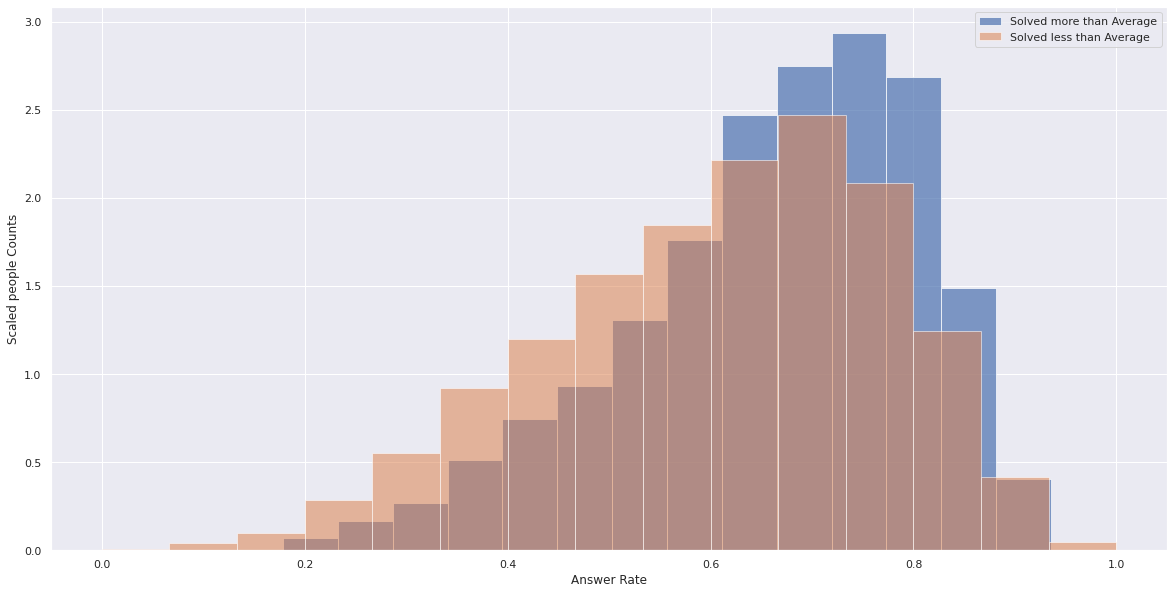

In [229]:
fig, ax = plt.subplots()
ans_mean = stu_groupby['testId'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled people Counts')
stu_groupby[stu_groupby['testId'] >= ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average')
stu_groupby[stu_groupby['testId'] < ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average')
ax.legend()

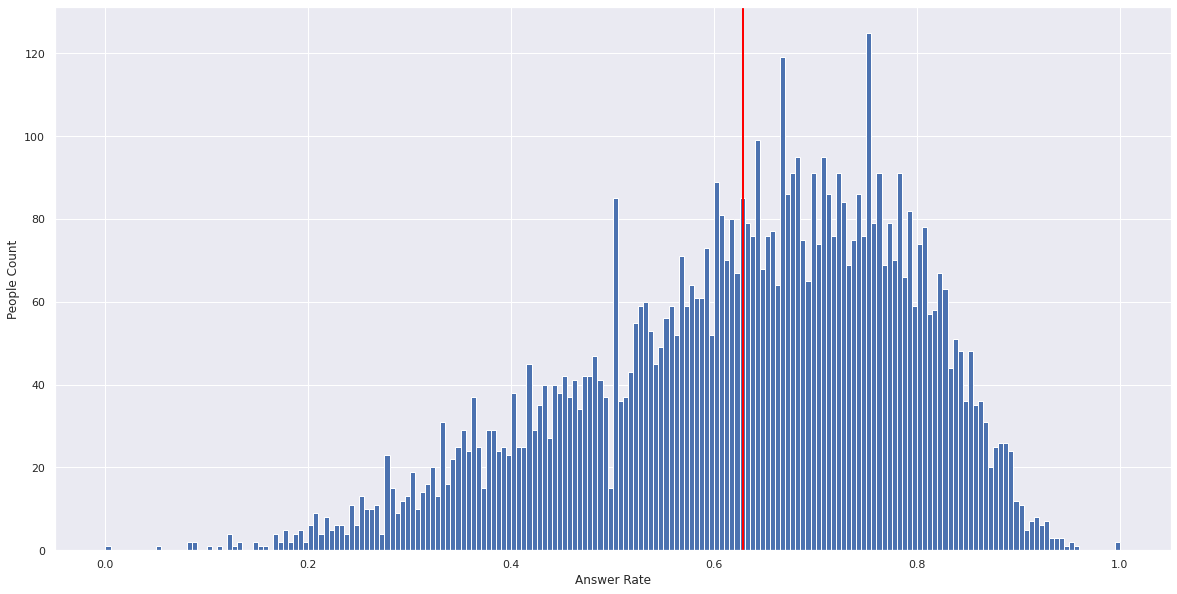

In [200]:
fig, ax = plt.subplots(figsize=(20,10))
stu_groupby['answerCode'].hist(bins=200)
# ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('People Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

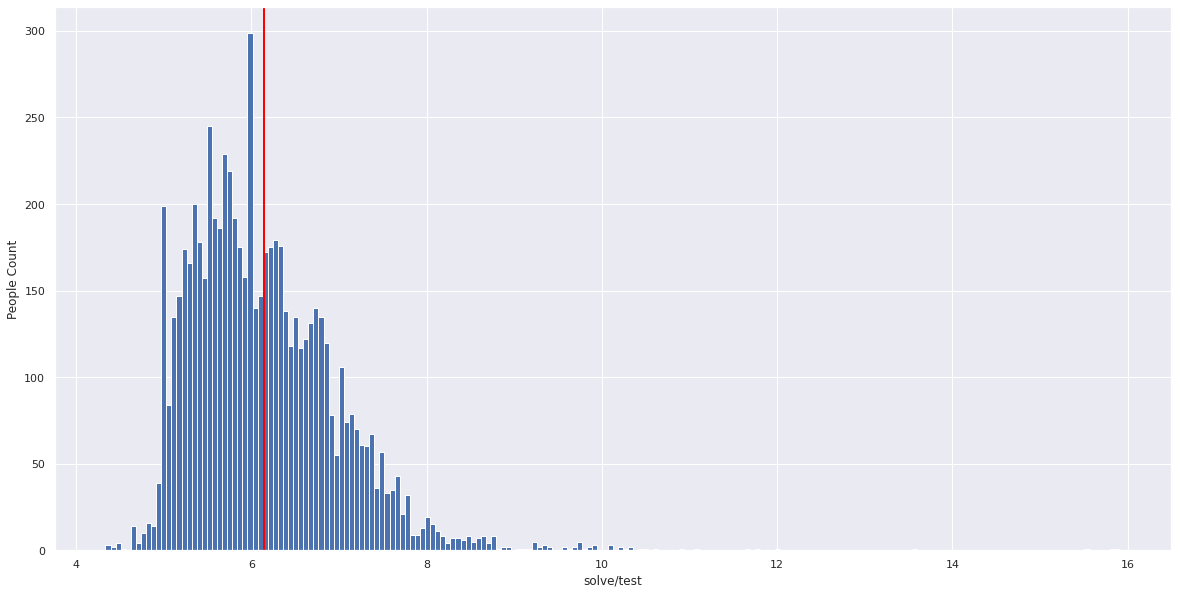

In [201]:
fig, ax = plt.subplots(figsize=(20,10))
stu_groupby['quiz_test_paper'].hist(bins=200)
ax.set_xlabel('solve/test')
ax.set_ylabel('People Count')
ax.axvline(stu_groupby['quiz_test_paper'].mean(), color='red')
ax.grid(b=True)

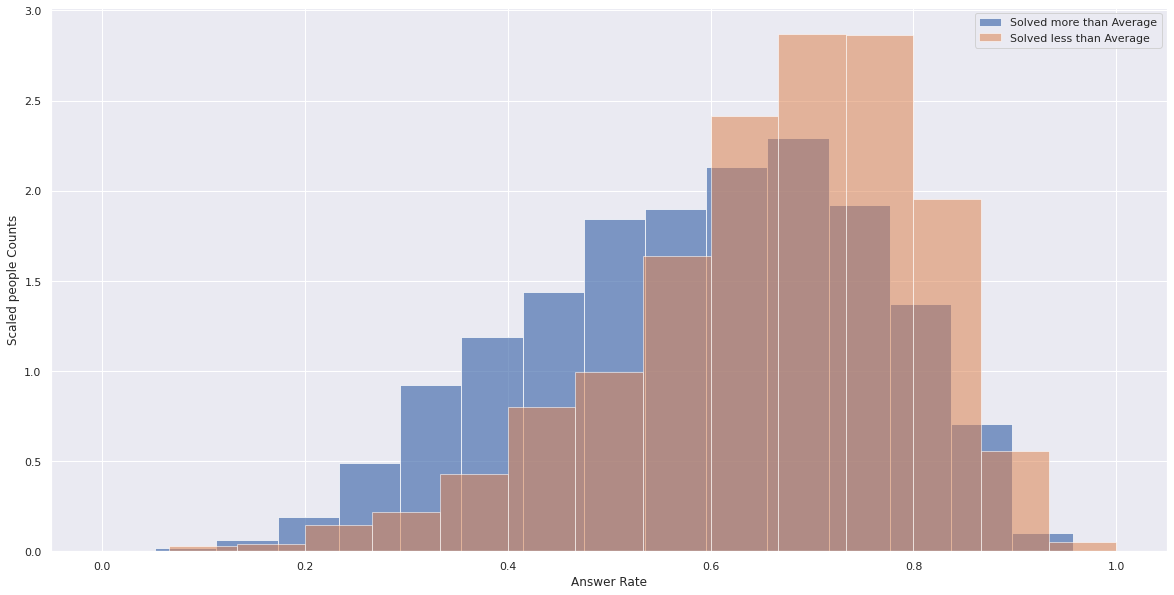

In [224]:
fig, ax = plt.subplots()
ans_mean = stu_groupby['quiz_test_paper'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled people Counts')
stu_groupby[stu_groupby['quiz_test_paper'] >= ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average')
stu_groupby[stu_groupby['quiz_test_paper'] < ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average')
ax.legend()

## 문제지 별 Data

In [148]:
stu_groupby_v2 = df.groupby('testId').agg({    
    'userID':'nunique',
    'level':'mean',
    'answerCode': percentile
})
stu_groupby_v2

,userID,level,answerCode
testId,,,
A010000001,311,1,0.926183
A010000002,303,1,0.931613
A010000003,314,1,0.846440
A010000004,299,1,0.883117
A010000005,313,1,0.855172
...,...,...,...
A090000070,43,9,0.418605
A090000071,45,9,0.336111
A090000072,45,9,0.418519


In [202]:
print(f"""{'-'*50}
문제지 당 푼 평균 인원 : {stu_groupby_v2.userID.mean().round(3)} 명
{'-'*50}""")

# stu_groupby[['assessmentItemID','testId']].mean()

--------------------------------------------------
문제지 당 푼 평균 인원 : 237.582 명
--------------------------------------------------


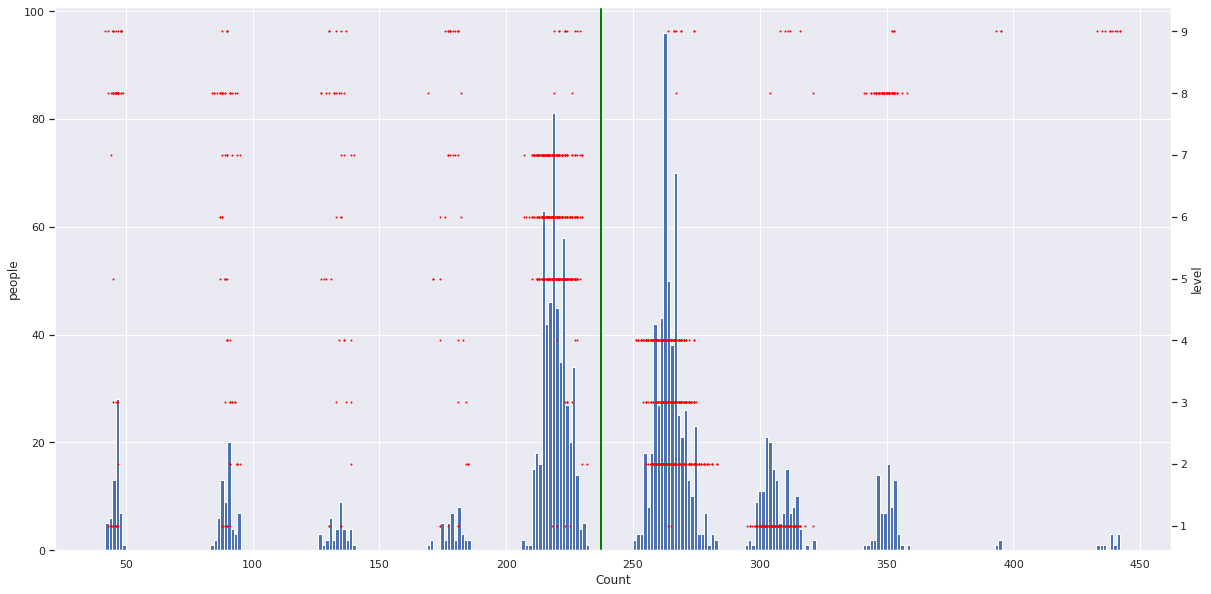

In [154]:
fig, ax = plt.subplots(figsize=(20,10))
stu_groupby_v2['userID'].hist(bins=300, ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('people')
# ax.grid(False)
ax.axvline(stu_groupby_v2['userID'].mean(), color='green')
ax2 = ax.twinx()
ax2.plot(stu_groupby_v2['userID'],  # x
         stu_groupby_v2['level'], # y
         linestyle='none', 
         marker='o', 
         markersize=1,
         color='red')
ax2.set_ylabel('level')
plt.show()

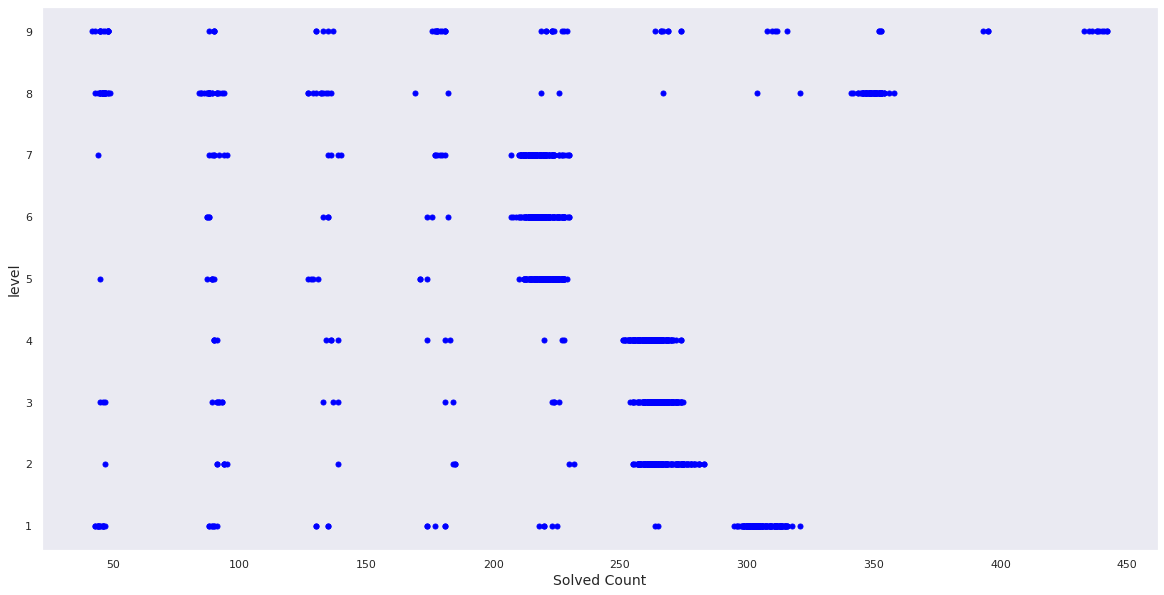

In [204]:
plt.plot(stu_groupby_v2['userID'],  # x
         stu_groupby_v2['level'], # y
         linestyle='none', 
         marker='o', 
         markersize=5,
         color='blue')
# plt.size(10,5)
plt.xlabel('Solved Count', fontsize=14)
plt.ylabel('level', fontsize=14)
plt.show()

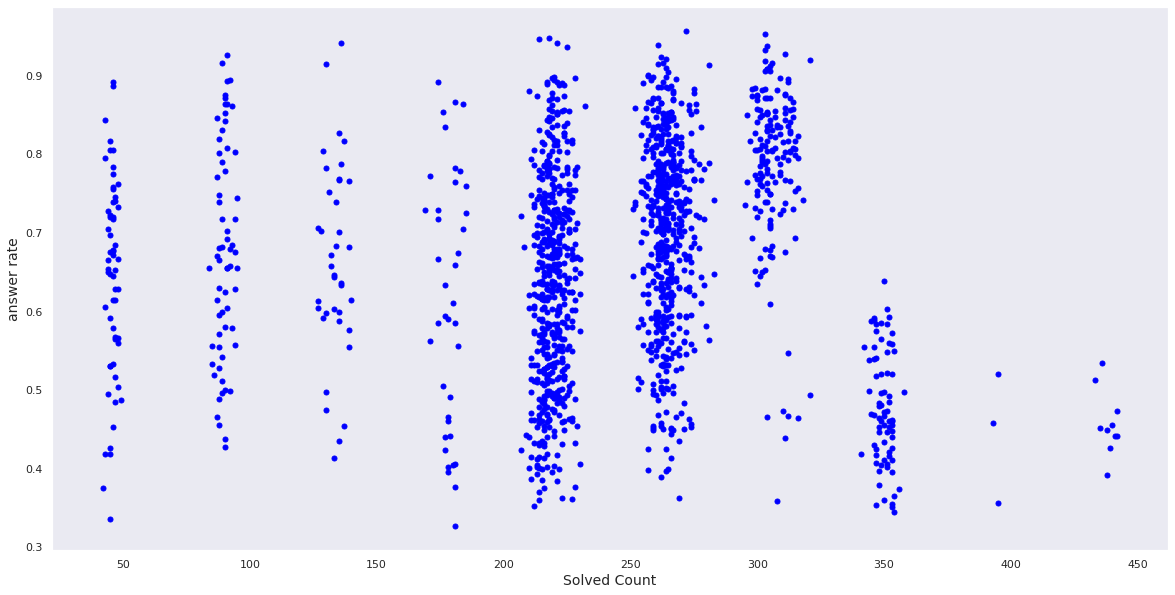

In [203]:
plt.plot(stu_groupby_v2['userID'],  # x
         stu_groupby_v2['answerCode'], # y
         linestyle='none', 
         marker='o', 
         markersize=5,
         color='blue')
# plt.size(10,5)
plt.xlabel('Solved Count', fontsize=14)
plt.ylabel('answer rate', fontsize=14)
plt.show()

In [162]:
b = df.groupby('testId').agg({    
    'answerCode': percentile
})


Text(0, 0.5, 'answer rate')

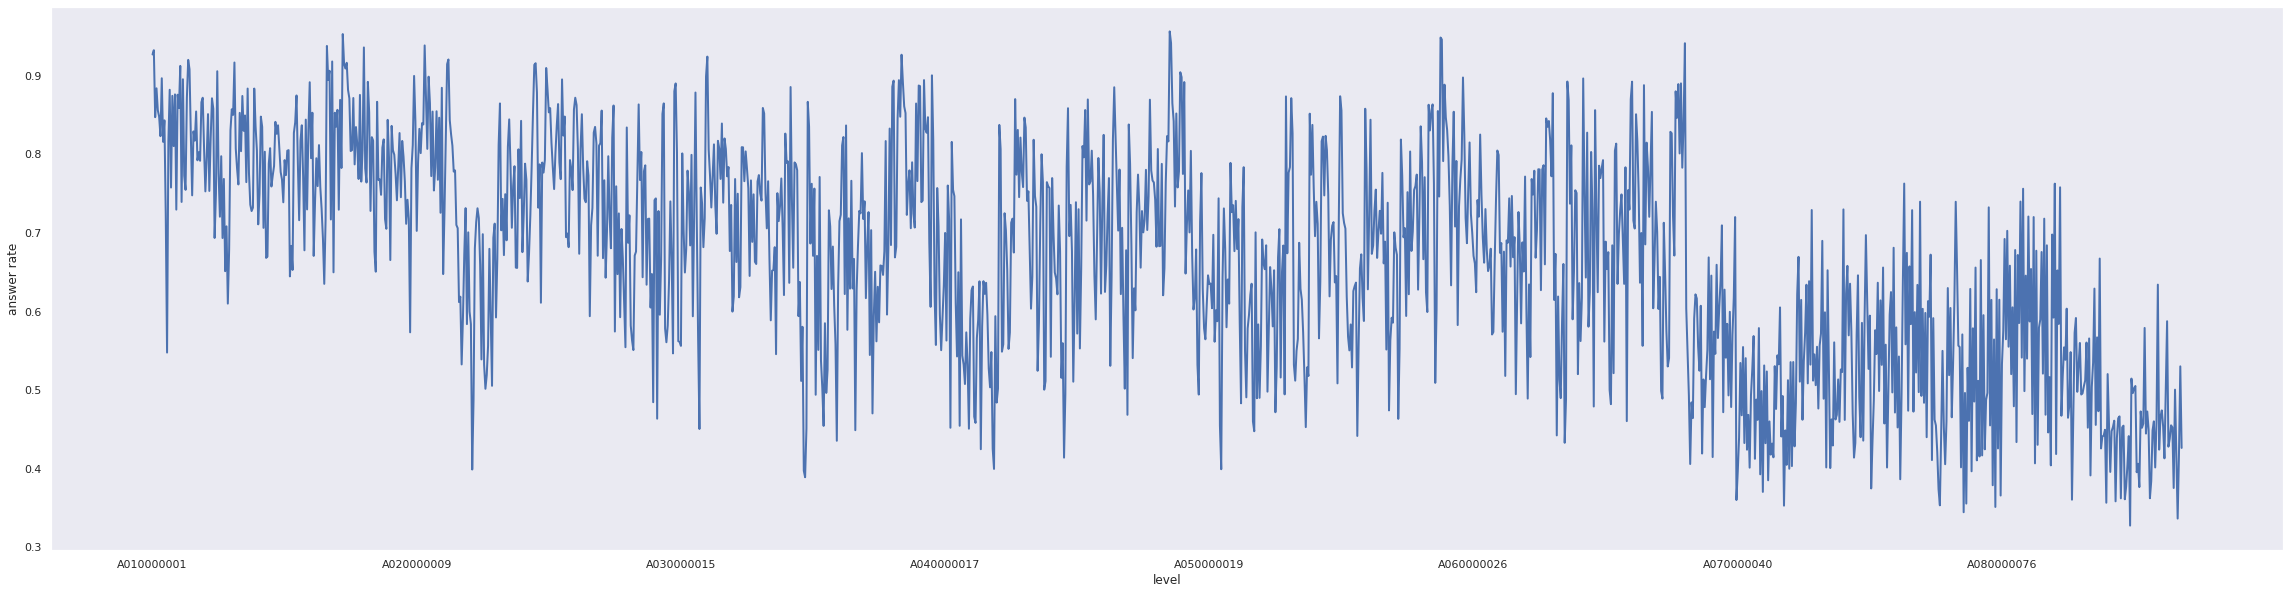

In [195]:
fig, ax = plt.subplots(figsize=(40,10))
stu_groupby_v2['answerCode'].plot(ax=ax)
ax.set_xlabel('level')
ax.set_ylabel('answer rate')

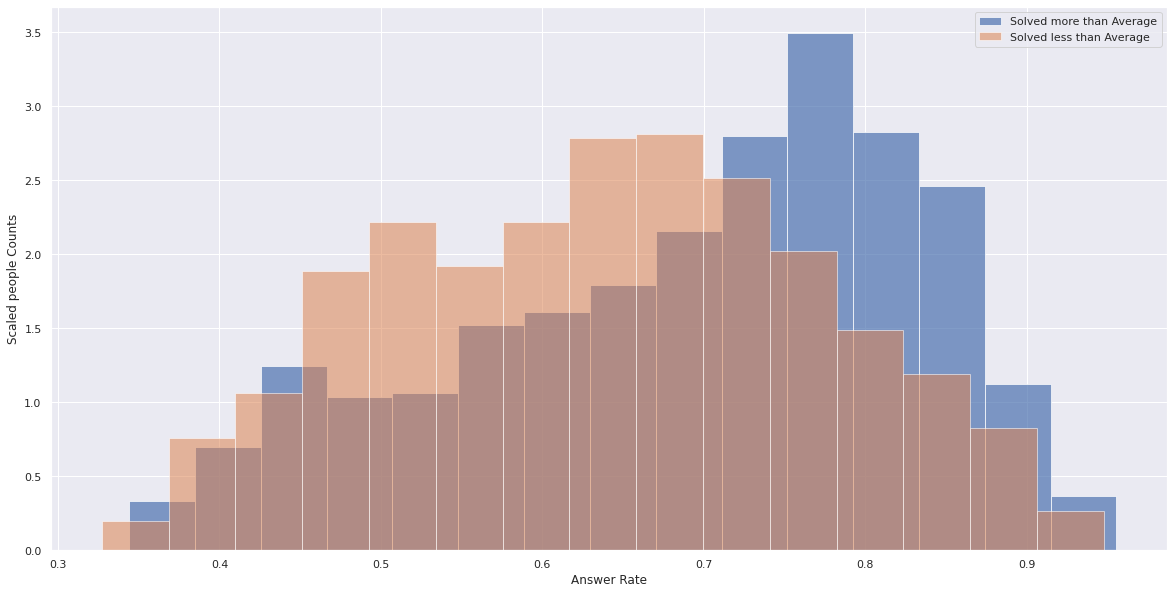

In [219]:
fig, ax = plt.subplots()
ans_mean = stu_groupby_v2['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled people Counts')
stu_groupby_v2[stu_groupby_v2['userID'] >= ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average')
stu_groupby_v2[stu_groupby_v2['userID'] < ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average')
ax.legend()

## Tag 별 Data

In [234]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'nunique',
    'answerCode': percentile,
    
})
tag_groupby['level']=tag_groupby['level'].round(3)
tag_groupby

,userID,answerCode,level
KnowledgeTag,,,
23,414,0.584444,8.0
24,347,0.614525,8.0
25,91,0.858696,8.0
26,416,0.614309,8.0
30,423,0.536178,8.0
...,...,...,...
11253,662,0.739374,4.0
11265,335,0.676211,4.0
11269,591,0.557716,4.0


In [235]:
tag_groupby.describe()

,userID,answerCode,level
count,912.000000,912.000000,912.000000
mean,483.335526,0.615524,5.613016
std,148.554696,0.148329,2.436137
min,42.000000,0.188940,1.000000
25%,410.000000,0.498239,4.000000
50%,504.000000,0.599585,6.000000
75%,584.000000,0.740288,8.000000
max,1027.000000,0.977778,9.000000


In [211]:
tag_groupby['level'].value_counts()

7.000    175
8.000    149
5.000     98
9.000     96
6.000     93
3.000     85
4.000     81
2.000     70
1.000     64
7.071      1
Name: level, dtype: int64

In [212]:
tag_groupby[tag_groupby['level'] == 7.071]  

,userID,answerCode,level
KnowledgeTag,,,
7863,1821,0.543108,7.071


In [238]:
df[df['KnowledgeTag'] ==7863].head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,level
230,0,A080037007,A080000037,0,2020-06-03 16:12:57,7863,8
5893,9,A070150003,A070000150,1,2020-12-11 20:16:41,7863,7
5894,9,A070150004,A070000150,1,2020-12-11 20:17:23,7863,7
5901,9,A070152003,A070000152,1,2020-12-14 20:44:46,7863,7
5911,9,A070154005,A070000154,1,2020-12-18 19:13:03,7863,7


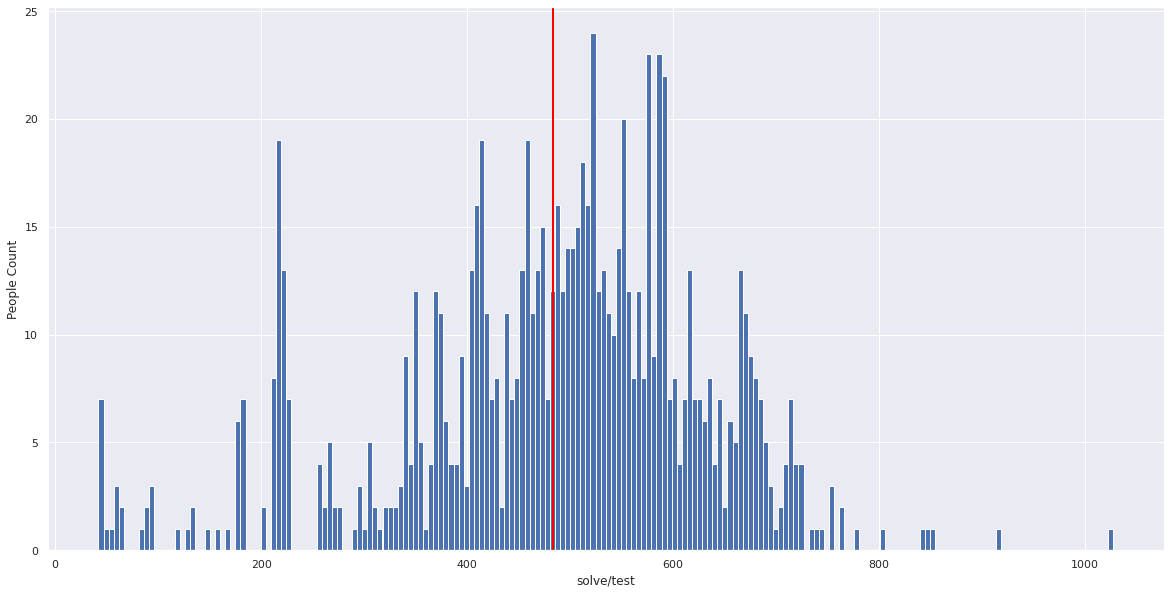

In [236]:
fig, ax = plt.subplots(figsize=(20,10))
tag_groupby['userID'].hist(bins=200)
ax.set_xlabel('solve/test')
ax.set_ylabel('People Count')
ax.axvline(tag_groupby['userID'].mean(), color='red')
ax.grid(b=True)

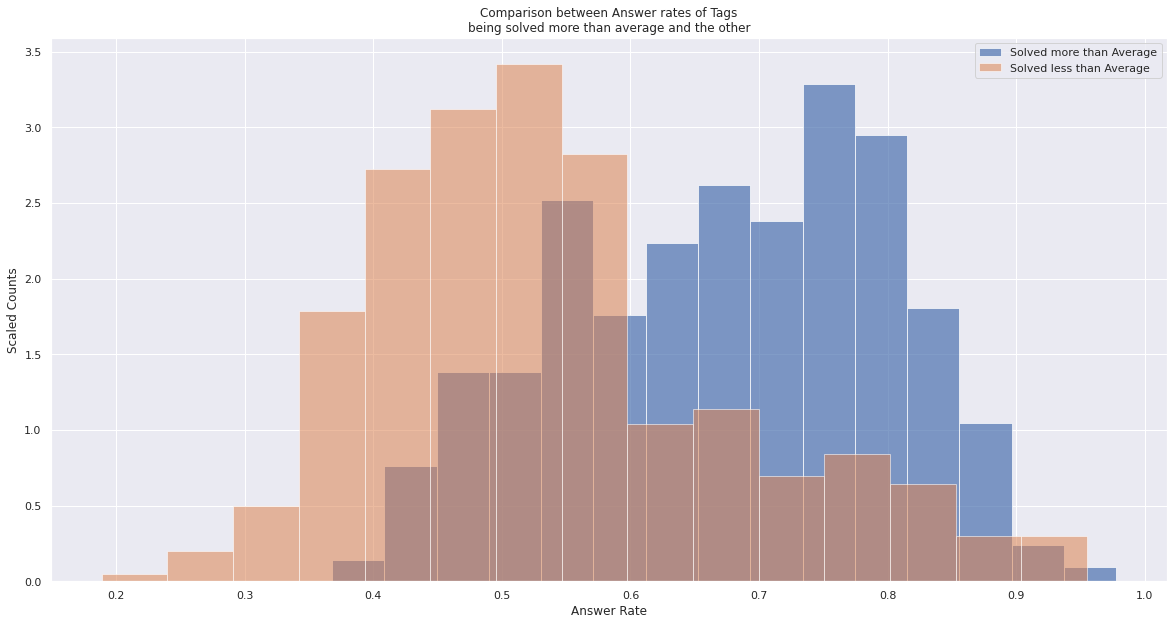

In [237]:
fig, ax = plt.subplots()
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')
tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average')
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average')
ax.legend()

## level 별 Data

In [243]:
level_groupby = df.groupby('level').agg({
    'userID': 'nunique',
    'assessmentItemID': 'count',
    'testId':'nunique',
    'answerCode': percentile,
    
})
level_groupby

,userID,assessmentItemID,testId,answerCode
level,,,,
1,2074,272082,192,0.800876
2,2241,268327,194,0.737593
3,2444,273762,198,0.702238
4,2666,267323,198,0.684056
5,2321,275773,193,0.658208
6,2132,264434,186,0.709232
7,1686,279164,164,0.521876
8,1517,246336,138,0.502598
9,671,119385,74,0.449948


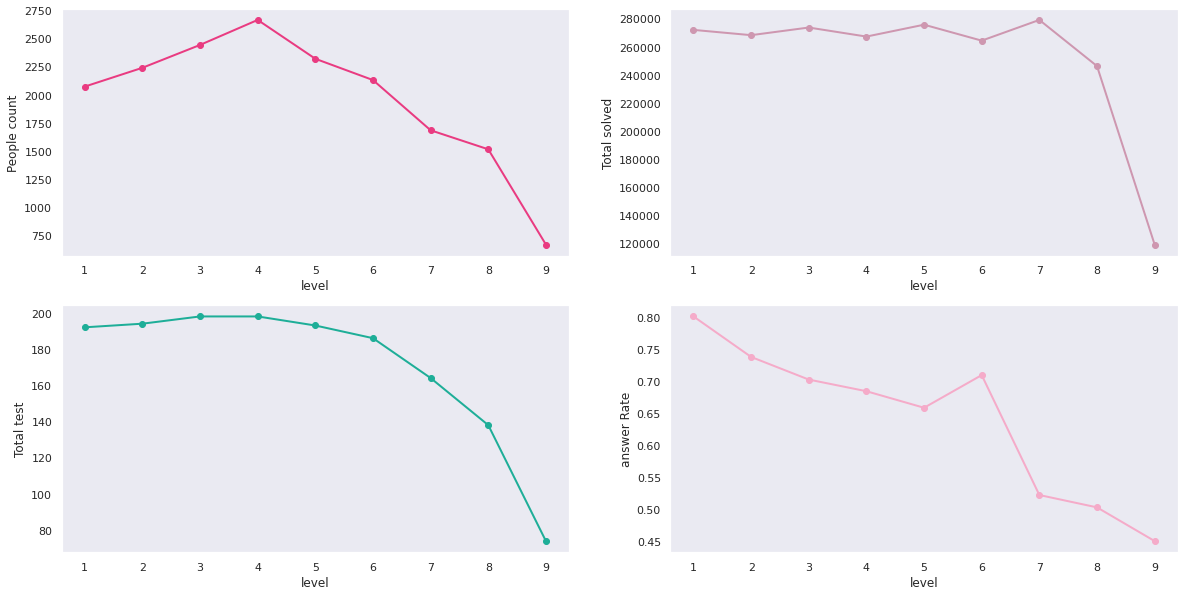

In [293]:
x_values = [1,2,3,4,5,6,7,8,9]
groups = [['userID','assessmentItemID'],['testId','answerCode']]
y_labels = [['People count', 'Total solved'],['Total test','answer Rate']]
colors = [['#e93b81','#ce97b0'],['#1eae98','#f5abc9']]
fig, ax = plt.subplots(2,2)

for i in range(2):
    for j in range(2):        
        ax[i][j].plot(x_values,level_groupby[groups[i][j]],marker='o',color=colors[i][j])
        ax[i][j].set_xlabel('level')
        ax[i][j].set_ylabel(y_labels[i][j])


## 문항을 많이 풀면 실력이 느는가

In [14]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

In [15]:
samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID')
samples

,assessmentItemID
userID,
7441,9
7390,13
7414,13
7252,13
7396,14
...,...
926,1773
394,1774
1112,1777


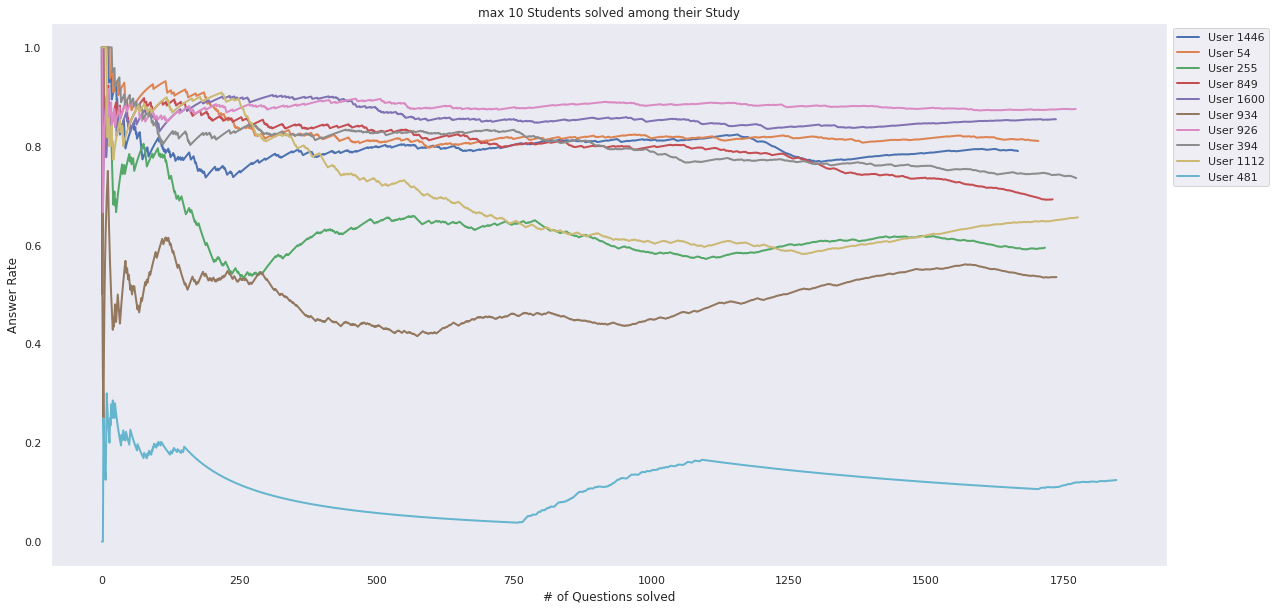

In [294]:
fig, ax = plt.subplots()
ax.set_title('max 10 Students solved among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[-11:-1] #7442//2-5:7442//2+5
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

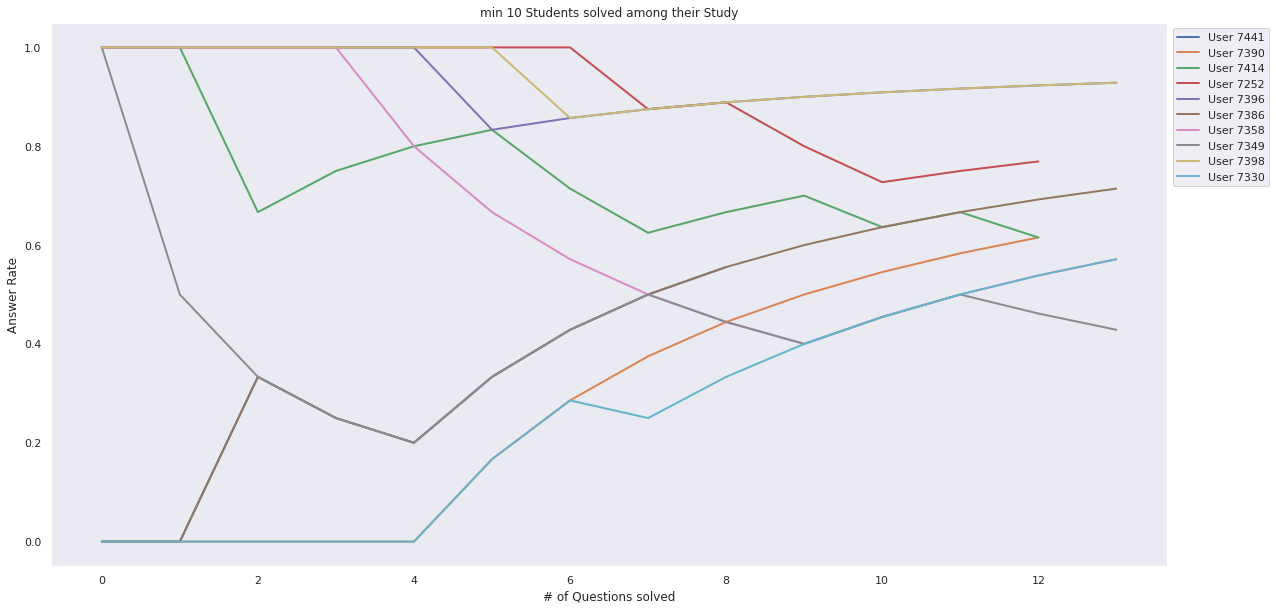

In [295]:
fig, ax = plt.subplots()
ax.set_title('min 10 Students solved among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[0:10] #7442//2-5:7442//2+5
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

## 정답률이 높은 학생들은 많이 풀었는가

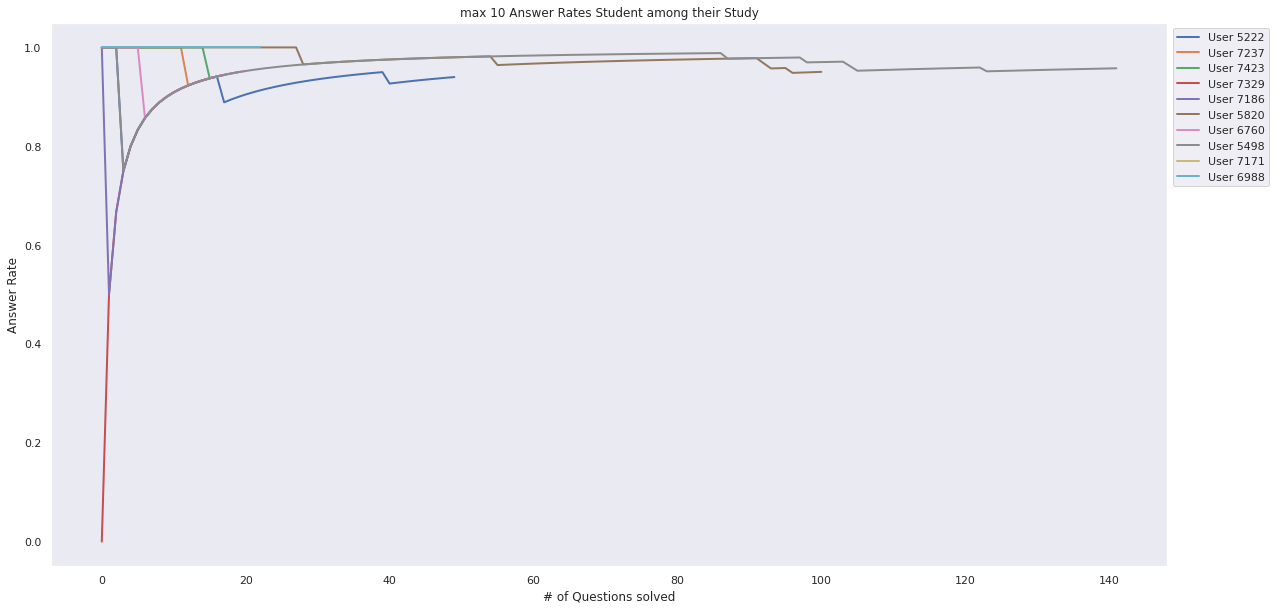

In [298]:
fig, ax = plt.subplots()
ax.set_title('max 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[-10:]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

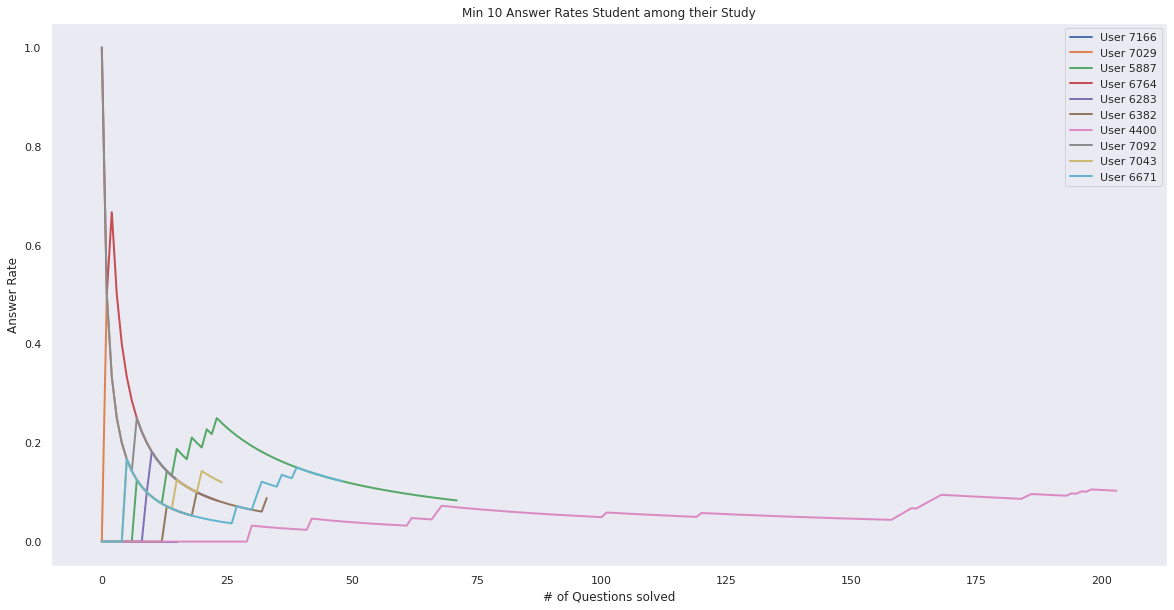

In [297]:
fig, ax = plt.subplots()
ax.set_title('Min 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[:10]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))